## Radargestützte Niederschlagsschätzung: Fallstudie Berlin, 12.7.2018

### Umgebung einrichten

In [1]:
import wradlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.spatial import KDTree
import helpers as h
import datetime as dt
from bokeh.plotting import figure, show, output_file, save
from bokeh.models import Label, ColumnDataSource, Range1d, LabelSet
import json
from collections import OrderedDict, defaultdict

/home/maik/miniconda3/envs/wradlib/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
%matplotlib inline

### Konfiguration

In [3]:
tstart = "2018-07-11 17:55:00"#"2018-07-11 23:55:00"
tend = "2018-07-12 21:50:00"
dxsrc = "dx/raa00-dx_10392-%s-pro---bin"
dtimes = wradlib.util.from_to(tstart, tend, 300)

In [4]:
site = (h.radars["pro"]["lon"], h.radars["pro"]["lat"], h.radars["pro"]["alt"])
r = h.specs_dx["r"]
az = h.specs_dx["az"]

In [5]:
# http://www.stadtentwicklung.berlin.de/service/gesetzestexte/de/download/geoinformation/koordinatenreferenzsysteme.pdf
proj = wradlib.georef.epsg_to_osr(25833)

In [6]:
# Berlin Ortsteile
dataset, inLayer = wradlib.io.open_vector("shapes/RBS_OD_ORT_1412.shp")
borders, orts = wradlib.georef.get_vector_coordinates(inLayer, key="Ortsteilna")
bbox = inLayer.GetExtent()

In [7]:
# Panke EZG
pankedset, pankeLayer = wradlib.io.open_vector("shapes/Einzugsgebiete_PankIS_ETRS89/EZG_Berlin_ETRS89.shp")
ezgs, ezgids = wradlib.georef.get_vector_coordinates(pankeLayer, key="TG_KEN")
pankebbox = pankeLayer.GetExtent()

### Niederschlagsschreiber (Berlin) laden

In [8]:
gauges = pd.read_csv("berlin_gauges.csv", sep=";", thousands=r',', encoding="cp1252", keep_default_na=False)
gdata = pd.read_csv("berlin_gages_timeseries.csv", sep=";", header=None)

In [9]:
gauges.columns = ["name", "x", "y", "veg", "flag"]
gdata.columns = ["dtime"] + [i for i in range(len(gauges))]

In [10]:
# Format dtime columns
gdata.dtime = pd.to_datetime(gdata.dtime, format="%d/%m/%Y %H:%M:%S")
# Convert to UTC
gdata.dtime = gdata.dtime - dt.timedelta(seconds=3600*2)
# Set datime index
gdata = gdata.set_index("dtime")
# 5 minute depths from cumulative depth
gdata = pd.DataFrame(np.array(gdata.iloc[1:]) - np.array(gdata.iloc[0:-1]), index=gdata.index[1:])
# Crop those times outside the time window
gdata = gdata.loc[tstart:tend]

In [11]:
gprec = gdata.sum()

In [12]:
# Rain gauge indices for good and bad gauges
gix = np.array(gauges.flag=="")
gix2 = np.array(gauges.veg=="geprüft") & gix
bix = ~gix2
gix = np.where(gix)[0]

### Niederschlagsschreiber als geojson exportieren

In [102]:
gauges_json = {
    "type": "FeatureCollection",
    "name": "gauges", 
    #"crs": {"type": "name", "properties": {"name": "urn:ogc:def:crs:OGC:1.3:CRS84"}},
    "features": []
}

In [103]:
gauges_feats = []
for i in range(len(gauges)):
    gauges_feats.append(       {
           "type": "Feature",
           "id": gauges.iloc[i].name,
           "geometry": {
               "type": "Point",
               "coordinates": wradlib.georef.reproject([gauges.iloc[i].x, gauges.iloc[i].y], projection_source=proj).tolist()
           },
           "properties": {
               "depth": gdata[i].sum()
           }
       })
gauges_json["features"] = gauges_feats

In [104]:
fpath = '/home/maik/git/web2py/applications/wradweb/static/geojson/gauges.geojson'
with open(fpath,'w') as geojson_file:
    json.dump(gauges_json, geojson_file)

### Niederschlagsschreiber (DWD) laden

In [13]:
dwd60mingg = pd.read_fwf("dwd/RR_Stundenwerte_Beschreibung_Stationen.txt", skiprows=2, encoding="cp1252",
                       names=["id", "von", "bis", "alt", "lat", "lon", "name", "state"])
dwd10mingg = pd.read_fwf("dwd/zehn_now_rr_Beschreibung_Stationen.txt", skiprows=2, encoding="cp1252",
                       names=["id", "von", "bis", "alt", "lat", "lon", "name", "state"])
dwd1mingg = pd.read_fwf("dwd/ein_now_rr_Beschreibung_Stationen.txt", skiprows=2, encoding="cp1252",
                       names=["id", "von", "bis", "alt", "lat", "lon", "name", "state"])

In [14]:
dwd60mingg = dwd60mingg.iloc[np.in1d(dwd60mingg.state, ["Berlin", "Brandenburg"])]
dwd60mingg["x"] =np.nan
dwd60mingg["y"] =np.nan
dwd10mingg = dwd10mingg.iloc[np.in1d(dwd10mingg.state, ["Berlin", "Brandenburg"])]
dwd1mingg = dwd1mingg.iloc[np.in1d(dwd1mingg.state, ["Berlin", "Brandenburg"])]

In [15]:
#dwd60mingg.bis.to_timestamp
#dwd60mingg.iloc[dwd60mingg.bis < "20180101"]

In [16]:
dwd60mingg[["x","y"]] = wradlib.georef.reproject(dwd60mingg[["lon","lat"]], projection_target=proj)
#dwd10mingg["x"],dwd10mingg["y"] = wradlib.georef.reproject(dwd10mingg[["lon","lat"]], projection_target=proj)
#dwd1mingg["x"] ,dwd1mingg["y"]  = wradlib.georef.reproject(dwd1mingg[["lon","lat"]], projection_target=proj)

### Niederschlagsschreiber LfU laden

In [17]:
lfugg = pd.read_table("lugv/stationen_lugv.txt", encoding="cp1252")
lfugg["x"] = np.nan
lfugg["y"] = np.nan
lfugg[["x","y"]] = wradlib.georef.reproject(lfugg[["lon","lat"]], projection_target=proj)

### Radardaten laden: DX-Produkt (lokal, Reflektivität)

In [18]:
dbz = np.zeros((len(dtimes), len(az), len(r))) * np.nan
for i, dtime in enumerate(dtimes):
    fpath = dxsrc % dtime.strftime("%y%m%d%H%M")
    try:
        data, meta = wradlib.io.read_dx(fpath)
        print(".", end="")
    except:
        print("Could not read: " % fpath)
    dbz[i] = data
print("")

................................................................................................................................................................................................................................................................................................................................................


### Niederschlag aus Reflektivität schätzen: mit und ohne Dämpfungskorrektur

In [19]:
dxprec = h.dbz2depth(dbz)

In [20]:
pia = wradlib.atten.correct_attenuation_constrained(dbz, a_max=1.67e-4, a_min=2.33e-5, n_a=100,
                                                    b_max=0.7, b_min=0.65, n_b=6, gate_length=1.,
                                                    constraints=[wradlib.atten.constraint_dbz,
                                                                 wradlib.atten.constraint_pia],
                                                    constraint_args=[[59.0], [20.0]])

/home/maik/miniconda3/envs/wradlib/lib/python3.7/site-packages/wradlib/trafo.py:142: RuntimeWarning: overflow encountered in power
  return 10. ** (x / 10.)


In [21]:
dxprec2 = h.dbz2depth(dbz + pia)

### Radardaten georeferenzieren

In [22]:
coord_dx = wradlib.georef.sweep_centroids(len(az), 1000., len(r), 0.5)
xyz_dx = wradlib.georef.spherical_to_proj(coord_dx[..., 0],
                                          np.degrees(coord_dx[..., 1]),
                                          coord_dx[..., 2], sitecoords=site, proj=proj)

### Radarniederschlag an den Niederschlagsschreibern extrahieren

In [23]:
# compute the KDTree
tree_dx = KDTree(list(zip(xyz_dx[...,0].ravel(), xyz_dx[...,1].ravel())))
# query the tree for nearest neighbours
dists_dx, ix_dx = tree_dx.query(list(zip(gauges.x, gauges.y)), k=9)

In [24]:
dx_at_gauge = np.median(dxprec.reshape((len(dtimes), -1))[:,ix_dx], axis=2)
dx2_at_gauge = np.median(dxprec2.reshape((len(dtimes), -1))[:,ix_dx], axis=2)

### RADOLAN RW-Produkt (stündlich, angeeicht) laden

In [25]:
tstart_rw = dtimes[0] + dt.timedelta(seconds=55*60)#.replace(minute=0) - dt.timedelta(seconds=10*60)
tend_rw = dtimes[-1]#.replace(minute=0) + dt.timedelta(seconds=10*60)
dtimes_rw = wradlib.util.from_to(tstart_rw, tend_rw, 3600)
rwprec = np.zeros((len(dtimes_rw), 900, 900)) * np.nan
rwsrc = "rw/raa01-rw_10000-%s-dwd---bin.gz"

In [26]:
for i, dtime in enumerate(dtimes_rw):
    fpath = rwsrc % dtime.strftime("%y%m%d%H%M")
    try:
        data, meta = wradlib.io.read_radolan_composite(fpath, missing=np.nan)
        print(".", end="")
    except:
        print("Could not read: " % fpath)
    rwprec[i] = data
print("")

............................


### Komposit georeferenzieren

In [27]:
# Get coordinates
rwcoords = wradlib.georef.get_radolan_grid(900,900)
x_rw, y_rw = wradlib.georef.reproject(rwcoords[:,:,0],
                                      rwcoords[:,:,1],
                                      projection_source=wradlib.georef.create_osr("dwd-radolan"),
                                      projection_target=proj)

In [28]:
print(np.unravel_index(np.argmin(np.sqrt((x_rw - bbox[0])**2 + (y_rw - bbox[2])**2)), x_rw.shape))
print(np.unravel_index(np.argmin(np.sqrt((x_rw - bbox[1])**2 + (y_rw - bbox[3])**2)), x_rw.shape))

(610, 742)
(653, 786)


### RW-Niederschlag an Niederschlagsschreibern extrahieren

In [29]:
# compute the KDTree
tree_rw = KDTree(list(zip(x_rw.ravel(), y_rw.ravel())))
# query the tree for nearest neighbours
dists_rw, ix_rw = tree_rw.query(list(zip(gauges.x, gauges.y)), k=9)

In [30]:
rw_at_gauge = np.median(rwprec.reshape((len(dtimes_rw), -1))[:,ix_rw], axis=2)

### Räumliches Setup

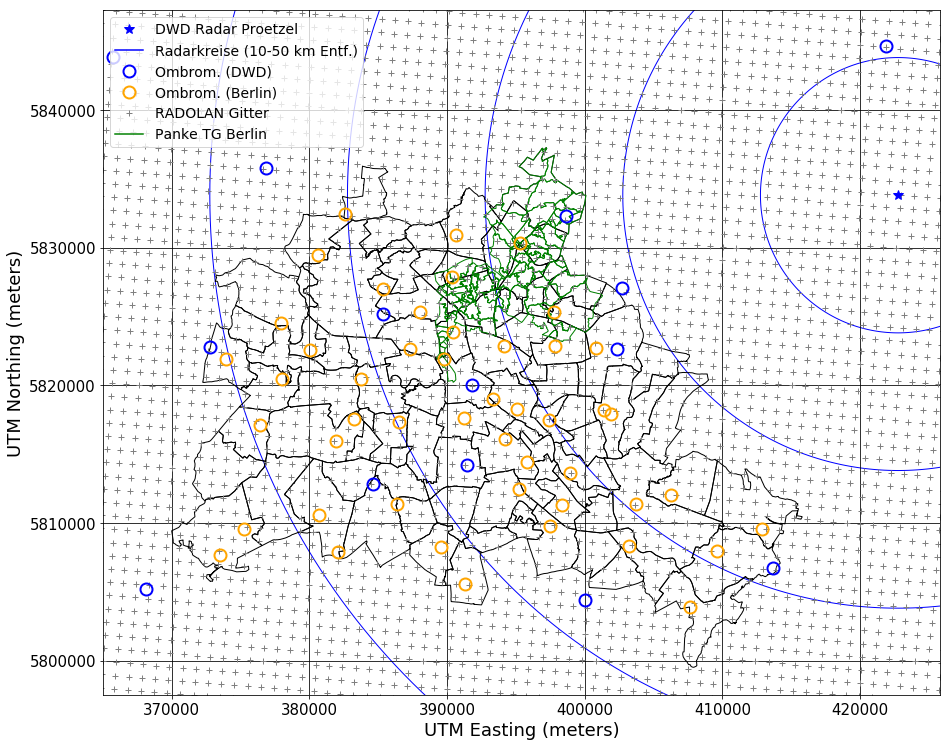

In [31]:
fig = plt.figure(figsize=(15,15))

ax = fig.add_subplot(111, aspect="equal")
#pm = plt.pcolormesh(x_rw, y_rw, np.ones((900,900)), 
#                    facecolor="None", edgecolor="grey", cmap=plt.cm.gist_gray, vmax=1, linewidth=0.1)
plt.plot(x_rw, y_rw, "k+", color="gray")
site_xy = wradlib.georef.reproject(site, projection_target=proj)
plt.plot(site_xy[0], site_xy[1], "b*", ms=10, label="DWD Radar Proetzel")
wradlib.vis.plot_ppi_crosshair(site=site, ranges=np.arange(1,6)*10000,
                               angles=[90], proj=proj,
                               line=dict(color='none'),
                               circle={'edgecolor': 'blue', "linewidth": 1., "linestyle":"-"})
ax.plot([], [], "b-", label="Radarkreise (10-50 km Entf.)")
#cb = plt.colorbar(pm, shrink=0.5)
wradlib.vis.add_lines(ax, borders, color='black', lw=1)
wradlib.vis.add_lines(ax, ezgs, color='green', lw=1)
plt.plot(dwd60mingg.x, dwd60mingg.y, "ro", markerfacecolor="None", mec="blue", mew=2, ms=12, label="Ombrom. (DWD)")
plt.plot(gauges.x, gauges.y, "go", markerfacecolor="None", mec="orange", mew=2, ms=12, label="Ombrom. (Berlin)")
#plt.plot(lfugg.x, lfugg.y, "go", markerfacecolor="None", mec="green", mew=2, ms=12, label="Ombrom. (LfU BB)")

#for i in range(len(gauges)):
#    color = "red"
#    if gauges.veg[i]=="geprüft":
#        color="white"
#    plt.text(gauges.x[i], gauges.y[i], "%d" % gageprec[i],
#             horizontalalignment='center', verticalalignment='center', color=color, fontsize=12)
plt.grid(color="black")
plt.xlabel("UTM Easting (meters)", fontsize=18)
plt.ylabel("UTM Northing (meters)", fontsize=18)
bufr = 10000
plt.xlim(bbox[0]-5000, bbox[1]+10000)
plt.ylim(bbox[2]-2000, bbox[3]+10000)
ax.tick_params(labelsize=15)
ax.plot([], [], "k+", color="gray", label="RADOLAN Gitter")
ax.plot([], [], "g-", color="green", label="Panke TG Berlin")
plt.legend(fontsize=14)
plt.savefig("figs/overviewmap.png", dpi=200)


# Zonal stats

### Berlin Ortsteile

In [32]:
mask, shape = wradlib.zonalstats.mask_from_bbox(xyz_dx[..., 0], xyz_dx[..., 1],
                                                {"left":bbox[0], "right":bbox[1], "bottom":bbox[2], "top":bbox[3]})

(5797520.396692546, 5842259.277727644)

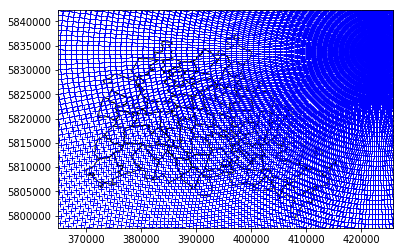

In [33]:
tmp = xyz_dx[..., 0:2].reshape((-1,2))
ax = plt.subplot(111)
plt.plot(tmp[:,0], tmp[:,1], "b+")
wradlib.vis.add_lines(ax, borders, color='black', lw=1)
plt.xlim(bbox[0]-5000, bbox[1]+10000)
plt.ylim(bbox[2]-2000, bbox[3]+5000)

In [34]:
borders_ = []
for border in borders:
    if border.ndim==1:
        borders_.append(border[0])
    else:
        borders_.append(border)

In [35]:
zd = wradlib.zonalstats.ZonalDataPoint(tmp, borders_, srs=proj, buf=500.)

In [36]:
# dump to file (for later use - see below)
zd.dump_vector('test_zonal_points_cart')
# Create instance of type GridPointsToPoly from zonal data object
obj1 = wradlib.zonalstats.ZonalStatsPoint(zd)

In [37]:
dxprec_at_reg = obj1.mean(dxprec.sum(axis=0).ravel())
dxprec2_at_reg = obj1.mean(dxprec2.sum(axis=0).ravel())

In [38]:
dxprec_at_reg_5min = np.array([obj1.mean(sweep.ravel()) for sweep in dxprec])
dxprec2_at_reg_5min = np.array([obj1.mean(sweep.ravel()) for sweep in dxprec2])

In [39]:
dfdx2avg = pd.DataFrame(dxprec2_at_reg_5min, index=dtimes)
dfdx2avg.columns = orts

In [40]:
def datetime(x):
    return np.array(x, dtype=np.datetime64)

In [41]:
with open('geojson/berlin_ortsteile.geojson', 'r') as f:
    ortjson = json.loads(f.read(), object_hook=OrderedDict)

#### Produce geojson and bokeh plots for Ortsteile

In [42]:
analy_dtimes = wradlib.util.from_to("2018-07-12 00:00:00", "2018-07-12 12:00:00", 3600)
for dtime in analy_dtimes:
    print(dtime)
    tmp = ortjson.copy()
    backintime = dtime - dt.timedelta(seconds=3600*6)
    fcastuntil = dtime + dt.timedelta(seconds=3600*2)
    dftmp = dfdx2avg.loc[backintime.isoformat(" "):dtime.isoformat(" ")]
    nowcast = dfdx2avg.loc[dtime.isoformat(" "):fcastuntil.isoformat(" ")]
    
    for i, feature in enumerate(tmp["features"]):
        tmp["features"][i]["properties"]["depth"] = dftmp[feature["properties"]["Ortsteilna"]].sum()
    
    fpath = '/home/maik/git/web2py/applications/wradweb/static/geojson/berlin_ortsteile_%s.geojson' % (dtime.isoformat("T"))
    with open(fpath,'w') as geojson_file:
        json.dump(tmp, geojson_file)

    for ort in orts:
        p1 = figure(x_axis_type="datetime", title=ort, plot_width=275, plot_height=275)
        p1.grid.grid_line_alpha=0.3
        p1.xaxis.axis_label = 'Zeit'
        p1.yaxis.axis_label = 'Kumulative Nd.höhe (mm)'

        p1.line(datetime(dftmp.index), dftmp[ort].cumsum(), color='black', legend='DX')
        p1.line(datetime(nowcast.index), nowcast[ort].cumsum()+dftmp[ort].sum(), color='black',
                line_dash="dotted", legend='Nowcast')
        p1.line([dtime, dtime], [-10,200], color='orange')
        mylabel = Label(x=dtime, y=90, x_units='data', text='VZP', text_color="orange",
                      x_offset=5, y_offset=0, render_mode='canvas')
        p1.add_layout(mylabel)
        p1.legend.location = "top_left"
        p1.y_range=Range1d(0, 100)

        output_file("/home/maik/git/web2py/applications/wradweb/static/html/%s_%s.html" % (ort.replace(" ", "_"), dtime.isoformat("T")), title=ort)
        #output_file("bokeh/%s_%s.html" % (ort, dtime.isoformat("T")), title=ort)

        save(p1) 

2018-07-12 00:00:00
2018-07-12 01:00:00
2018-07-12 02:00:00
2018-07-12 03:00:00
2018-07-12 04:00:00
2018-07-12 05:00:00
2018-07-12 06:00:00
2018-07-12 07:00:00
2018-07-12 08:00:00
2018-07-12 09:00:00
2018-07-12 10:00:00
2018-07-12 11:00:00
2018-07-12 12:00:00


### Panke

In [43]:
pankemask, pankeshape = wradlib.zonalstats.mask_from_bbox(xyz_dx[..., 0], xyz_dx[..., 1],
                                                {"left":pankebbox[0], "right":pankebbox[1], "bottom":pankebbox[2], "top":pankebbox[3]})

ezgs_ = []
for ezg in ezgs:
    if ezg.ndim==1:
        ezgs_.append(ezg[0])
        print("Invalid geometry.")
    else:
        ezgs_.append(ezg)

pankezd = wradlib.zonalstats.ZonalDataPoint(xyz_dx[..., 0:2].reshape((-1,2)), ezgs_, srs=proj, buf=500.)

# dump to file (for later use - see below)
pankezd.dump_vector('panke_zonal_points_cart')
# Create instance of type GridPointsToPoly from zonal data object
pankeobj = wradlib.zonalstats.ZonalStatsPoint(pankezd)

panke_dxprec_at_reg = pankeobj.mean(dxprec.sum(axis=0).ravel())
panke_dxprec2_at_reg = pankeobj.mean(dxprec2.sum(axis=0).ravel())

panke_dxprec_at_reg_5min = np.array([pankeobj.mean(sweep.ravel()) for sweep in dxprec])
panke_dxprec2_at_reg_5min = np.array([pankeobj.mean(sweep.ravel()) for sweep in dxprec2])

panke_dfdx2avg = pd.DataFrame(panke_dxprec2_at_reg_5min, index=dtimes)
panke_dfdx2avg.columns = ezgids

In [44]:
#with open('geojson/panke.geojson', 'r') as f:
#    pankefeats = json.loads(f.read(), object_hook=OrderedDict)
#
#for i, feature in enumerate(pankefeats["features"]):
#    pankefeats["features"][i]["properties"]["depth"] = panke_dxprec2_at_reg[i]
#
#with open('/home/maik/git/web2py/applications/wradweb/static/geojson/panke_depth.geojson', 'w') as geojson_file:
#    json.dump(pankefeats, geojson_file)   

In [45]:
#for i, ezgid in enumerate(ezgids):
#    print(".", end="")
#    p1 = figure(x_axis_type="datetime", title=ezgid, plot_width=275, plot_height=275)
#    p1.grid.grid_line_alpha=0.3
#    p1.xaxis.axis_label = 'Zeit'
#    p1.yaxis.axis_label = 'Kumulative Nd.höhe (mm)'
#
#    p1.line(datetime(panke_dfdxavg.index), panke_dfdxavg[ezgid].cumsum(), color='black', legend='DX')
#    p1.legend.location = "top_left"
#
#    output_file("/home/maik/git/web2py/applications/wradweb/static/html/panke_%s.html" % ezgid, title=ezgid)
#
#    save(p1)  # open a browser   

#### Produce geojson and bokeh plots for EZG Panke

In [46]:
with open('geojson/panke.geojson', 'r') as f:
    pankefeats = json.loads(f.read(), object_hook=OrderedDict)

In [47]:
analy_dtimes = wradlib.util.from_to("2018-07-12 00:00:00", "2018-07-12 12:00:00", 3600)
for dtime in analy_dtimes:
    print(dtime)
    tmp = pankefeats.copy()
    backintime = dtime - dt.timedelta(seconds=3600*6)
    fcastuntil = dtime + dt.timedelta(seconds=3600*2)
    dftmp = panke_dfdx2avg.loc[backintime.isoformat(" "):dtime.isoformat(" ")]
    nowcast = panke_dfdx2avg.loc[dtime.isoformat(" "):fcastuntil.isoformat(" ")]
    
    for i, feature in enumerate(tmp["features"]):
        tmp["features"][i]["properties"]["depth"] = dftmp[feature["properties"]["TG_KEN"]].sum()
    
    fpath = '/home/maik/git/web2py/applications/wradweb/static/geojson/panke_%s.geojson' % (dtime.isoformat("T"))
    with open(fpath,'w') as geojson_file:
        json.dump(tmp, geojson_file)

    for ezgid in ezgids:
        p1 = figure(x_axis_type="datetime", title=ezgid, plot_width=275, plot_height=275)
        p1.grid.grid_line_alpha=0.3
        p1.xaxis.axis_label = 'Zeit'
        p1.yaxis.axis_label = 'Kumulative Nd.höhe (mm)'

        p1.line(datetime(dftmp.index), dftmp[ezgid].cumsum(), color='black', legend='DX')
        p1.line(datetime(nowcast.index), nowcast[ezgid].cumsum()+dftmp[ezgid].sum(), color='black',
                line_dash="dotted", legend='Nowcast')
        p1.line([dtime, dtime], [-10,200], color='orange')
        mylabel = Label(x=dtime, y=90, x_units='data', text='VZP', text_color="orange",
                      x_offset=5, y_offset=0, render_mode='canvas')
        p1.add_layout(mylabel)
        p1.legend.location = "top_left"
        p1.y_range=Range1d(0, 100)

        output_file("/home/maik/git/web2py/applications/wradweb/static/html/panke_%s_%s.html" % (ezgid, dtime.isoformat("T")), title=ezgid)
        #output_file("bokeh/%s_%s.html" % (ort, dtime.isoformat("T")), title=ort)

        save(p1) 

2018-07-12 00:00:00
2018-07-12 01:00:00
2018-07-12 02:00:00
2018-07-12 03:00:00
2018-07-12 04:00:00
2018-07-12 05:00:00
2018-07-12 06:00:00
2018-07-12 07:00:00
2018-07-12 08:00:00
2018-07-12 09:00:00
2018-07-12 10:00:00
2018-07-12 11:00:00
2018-07-12 12:00:00


# Aneichung und Interpolation

## Kreuzvalidierung

Wird die Niederschlagsschätzung an den geprüften Niederschlagsschreibern besser, wenn wir die ungeprüften Niederschlagsschreiber als Prädiktoren miteinbeziehen?

In [ ]:
# Interpolation using all gauges
obs_coords = np.array(gauges.loc[:,["x", "y"]]).astype("f4")
rad_coords = xyz_dx[...,0:2].reshape((-1,2))

go_all = wradlib.adjust.GageOnly(obs_coords, rad_coords, nnear_raws=9)
gosum_all_obs, gosum_all_est = go_all.xvalidate(np.array(gdata.sum()[:]),
                                                dxprec.sum(axis=0).ravel())
#gosum_all_obs, gosum_all_est = go_all.xvalidate(np.array(gageprec[:]), 
#                                                np.ones(len(gageprec[:])))

In [ ]:
# Interpolation using "good" gauges
obs_coords_gix = np.array(gauges.loc[gix,["x", "y"]]).astype("f4")

go_gix = wradlib.adjust.GageOnly(obs_coords_gix, rad_coords, nnear_raws=9)
gosum_gix_obs, gosum_gix_est = go_gix.xvalidate(np.array(gdata.sum()[gix]),
                                                dxprec.sum(axis=0).ravel())

In [ ]:
go_all_5min = np.zeros(gdata.shape)
for i in range(len(go_all_5min)):
    _, go_all_5min[i] = go_all.xvalidate(np.array(gdata.iloc[i]), dxprec[i].ravel())    

## Interpolation auf Gitter

In [ ]:
# Target coordinates
xtrg = np.arange(bbox[0]-1000, bbox[1]+2000, 1000)
ytrg = np.arange(bbox[2]-1000, bbox[3]+2000, 1000)
trg = wradlib.util.gridaspoints(ytrg, xtrg)
#trg = np.meshgrid(xtrg, ytrg)
#trg = np.vstack( (trg[0].ravel(), trg[1].ravel()) ).T

In [ ]:
# Interpolation objects
idw = wradlib.ipol.Idw(obs_coords_gix, trg)
ip = idw(np.array(gdata[gix].sum())).reshape((len(ytrg), len(xtrg)))

## Flächenhafte Darstellung aller Produkte

In [ ]:
from matplotlib.colors import BoundaryNorm
gridcolor = "lightgray"
fontsize = 18

cmap = plt.cm.nipy_spectral
bounds = np.arange(0, 80, 5)
norm = BoundaryNorm(bounds, cmap.N)

fig = plt.figure(figsize=(15,13))

ax = fig.add_subplot(221, aspect="equal")
ax, pm = wradlib.vis.plot_ppi(dxprec.sum(axis=0), r=r, az=az, site=site, 
                              proj=proj, cmap=cmap, norm=norm, ax=ax)
wradlib.vis.add_lines(ax, borders, color='black', lw=0.3)
plt.grid(color=gridcolor)
#plt.xlabel("UTM Easting", fontsize=fontsize)
plt.ylabel("UTM Northing", fontsize=fontsize)
plt.xlim(bbox[0], bbox[1])
plt.ylim(bbox[2], bbox[3])
plt.title("DX2R", fontsize=fontsize)
for i in gix:
    plt.text(gauges.x[i], gauges.y[i], "%d" % gdata.sum()[i],
             horizontalalignment='center', verticalalignment='center', 
             color="white", fontsize=12)
ax.tick_params(labelsize=12)

ax = fig.add_subplot(222, aspect="equal")
ax, pm = wradlib.vis.plot_ppi(dxprec2.sum(axis=0), r=r, az=az, site=site, 
                              proj=proj, cmap=cmap, norm=norm, ax=ax)
wradlib.vis.add_lines(ax, borders, color='black', lw=0.3)
plt.grid()
#plt.xlabel("UTM Easting")
#plt.ylabel("UTM Northing")
plt.xlim(bbox[0], bbox[1])
plt.ylim(bbox[2], bbox[3])
plt.title("DXcorr2R", fontsize=fontsize)
for i in gix:
    plt.text(gauges.x[i], gauges.y[i], "%d" % gdata.sum()[i],
             horizontalalignment='center', verticalalignment='center', 
             color="white", fontsize=12)
ax.tick_params(labelsize=12)


ax = fig.add_subplot(223, aspect="equal")
pm = plt.pcolormesh(x_rw, y_rw, np.ma.masked_invalid(rwprec.sum(axis=0)), cmap=cmap, norm=norm)
wradlib.vis.add_lines(ax, borders, color='black', lw=0.3)
plt.grid()
plt.xlabel("UTM Easting", fontsize=fontsize)
plt.ylabel("UTM Northing", fontsize=fontsize)
plt.xlim(bbox[0], bbox[1])
plt.ylim(bbox[2], bbox[3])
plt.title("RW", fontsize=fontsize)
for i in gix:
    plt.text(gauges.x[i], gauges.y[i], "%d" % gdata.sum()[i],
             horizontalalignment='center', verticalalignment='center', 
             color="white", fontsize=12)
ax.tick_params(labelsize=12)


ax = fig.add_subplot(224, aspect="equal")
pm = plt.pcolormesh(xtrg, ytrg, ip, cmap=cmap, norm=norm)
wradlib.vis.add_lines(ax, borders, color='black', lw=0.3)
plt.grid()
plt.xlabel("UTM Easting", fontsize=fontsize)
#plt.ylabel("UTM Northing")
plt.xlim(bbox[0], bbox[1])
plt.ylim(bbox[2], bbox[3])
plt.title("OmBerlin", fontsize=fontsize)
for i in gix:
    plt.text(gauges.x[i], gauges.y[i], "%d" % gdata.sum()[i],
             horizontalalignment='center', verticalalignment='center', 
             color="white", fontsize=12)
# Good gages which are in fact bad
bgix = np.where(np.array(gdata.sum()[gix]) < 20.)[0]
for i in gix[bgix]:
    plt.plot(gauges.x[i], gauges.y[i], "ro", mfc="None", ms=20, mew=2)
ax.tick_params(labelsize=12)

#fig.subplots_adjust(bottom=0.01)
cbar_ax = fig.add_axes([0.2, 0.04, 0.6, 0.03])
cb = fig.colorbar(pm, cax=cbar_ax, orientation="horizontal", extend="max")
cb.set_label("mm", fontsize=fontsize)
cb.ax.tick_params(labelsize=15)

#plt.tight_layout()


plt.savefig("figs/depthmap.png", dpi=200)





### Diagnoseplot

In [ ]:
def rmse2plot(x,y, maxval):
    plt.text(0.05*maxval, 0.9*maxval, "RMSE=%.1f mm" % h.rmse(x, y),
             fontsize=14, backgroundcolor="white")

In [ ]:
maxval = 70
fontsize = 14
ms=12
fig = plt.figure(figsize=(9,9))
ax = plt.subplot(221, aspect="equal")
plt.plot([-10, 100], [-10, 100], "k--")
plt.plot(np.array(gdata.sum()), dx_at_gauge.sum(axis=0), "k+", ms=ms, label="alle")
plt.plot(np.array(gdata.sum())[gix], dx_at_gauge.sum(axis=0)[gix], "g+", ms=ms, label="ungeflaggt")
plt.plot(np.array(gdata.sum())[gix][bgix], dx_at_gauge.sum(axis=0)[gix][bgix], "ro", mfc="None", ms=ms, label="fehlerhaft")
plt.xlim(0,maxval)
plt.ylim(0,maxval)
plt.xlabel("Ground truth (mm)", fontsize=fontsize)
plt.ylabel("QPE (mm)", fontsize=fontsize)
plt.grid()
plt.title("DX2R", fontsize=fontsize)
rmse2plot(np.array(gdata.sum())[gix], dx_at_gauge.sum(axis=0)[gix], maxval)
ax.tick_params(labelsize=fontsize)

ax = plt.subplot(222, aspect="equal")
plt.plot([-10, 100], [-10, 100], "k--")
plt.plot(np.array(gdata.sum()), dx2_at_gauge.sum(axis=0), "k+", ms=ms, label="alle")
plt.plot(np.array(gdata.sum())[gix], dx2_at_gauge.sum(axis=0)[gix], "g+", ms=ms, label="ungeflaggt")
plt.plot(np.array(gdata.sum())[gix][bgix], dx2_at_gauge.sum(axis=0)[gix][bgix], "ro", mfc="None", ms=ms, label="unplausibel")
plt.xlim(0,maxval)
plt.ylim(0,maxval)
plt.xlabel("Ground truth (mm)", fontsize=fontsize)
plt.ylabel("QPE (mm)", fontsize=fontsize)
plt.grid()
plt.title("DXcorr2R", fontsize=fontsize)
rmse2plot(np.array(gdata.sum())[gix], dx2_at_gauge.sum(axis=0)[gix], maxval)
ax.tick_params(labelsize=fontsize)
plt.legend(loc="lower right", fontsize=fontsize)

ax = plt.subplot(223, aspect="equal")
plt.plot([-10, 100], [-10, 100], "k--")
plt.plot(np.array(gdata.sum()), rw_at_gauge.sum(axis=0), "k+", ms=ms)
plt.plot(np.array(gdata.sum())[gix], rw_at_gauge.sum(axis=0)[gix], "g+", ms=ms)
plt.plot(np.array(gdata.sum())[gix][bgix], rw_at_gauge.sum(axis=0)[gix][bgix], "ro", mfc="None", ms=ms)
plt.xlim(0,maxval)
plt.ylim(0,maxval)
plt.xlabel("Ground truth (mm)", fontsize=fontsize)
plt.ylabel("QPE (mm)", fontsize=fontsize)
plt.grid()
plt.title("RW", fontsize=fontsize)
rmse2plot(np.array(gdata.sum())[gix], rw_at_gauge.sum(axis=0)[gix], maxval)
ax.tick_params(labelsize=fontsize)

ax = plt.subplot(224, aspect="equal")
plt.plot([-10, 100], [-10, 100], "k--")
#plt.plot(gosum_all_obs, gosum_all_est, "k+")
#plt.plot(gosum_all_obs[gix], gosum_all_est[gix], "g+")
plt.plot(gosum_gix_obs, gosum_gix_est, "g+", ms=ms)
plt.plot(gosum_gix_obs[bgix], gosum_gix_est[bgix], "ro", mfc="none", ms=ms)
plt.xlim(0,maxval)
plt.ylim(0,maxval)
plt.xlabel("Ground truth (mm)", fontsize=fontsize)
plt.ylabel("QPE (mm)", fontsize=fontsize)
plt.grid()
plt.title("OmBerlin", fontsize=fontsize)
rmse2plot(gosum_gix_obs, gosum_gix_est, maxval)
ax.tick_params(labelsize=fontsize)

plt.tight_layout()

plt.savefig("figs/scatter.png", dpi=200)

In [ ]:
maxval = 5
fig = plt.figure(figsize=(9,9))
ax = plt.subplot(131, aspect="equal")
plt.plot([-10, 100], [-10, 100], "k--")
plt.plot(np.array(gdata)[:,gix2], dx_at_gauge[:,gix2], "k+")
#plt.plot(np.array(gdata.sum())[gix], dx_at_gauge.sum(axis=0)[gix], "g+")
#plt.plot(np.array(gdata.sum())[bix], dx_at_gauge.sum(axis=0)[bix], "ro", markerfacecolor="none")
plt.xlim(0,maxval)
plt.ylim(0,maxval)
plt.xlabel("Gages (mm)")
plt.ylabel("Radar (mm)")
plt.grid()
plt.title("DX")
rmse2plot(np.array(gdata)[:,gix], dx_at_gauge[:,gix], maxval)

ax = plt.subplot(132, aspect="equal")
plt.plot([-10, 100], [-10, 100], "k--")
plt.plot(np.array(gdata)[:,gix2], dx2_at_gauge[:,gix2], "k+")
#plt.plot(np.array(gdata.sum())[gix], dx2_at_gauge.sum(axis=0)[gix], "g+")
#plt.plot(np.array(gdata.sum())[bix], dx2_at_gauge.sum(axis=0)[bix], "ro", markerfacecolor="none")
plt.xlim(0,maxval)
plt.ylim(0,maxval)
plt.xlabel("Gages (mm)")
plt.ylabel("Radar (mm)")
plt.grid()
plt.title("DX, att. corr.")
rmse2plot(np.array(gdata)[:,gix], dx2_at_gauge[:,gix], maxval)

#ax = plt.subplot(223, aspect="equal")
#plt.plot([-10, 100], [-10, 100], "k--")
#plt.plot(np.array(gdata), rw_at_gauge, "k+")
#plt.plot(np.array(gdata.sum())[gix], rw_at_gauge.sum(axis=0)[gix], "g+")
#plt.plot(np.array(gdata.sum())[bix], rw_at_gauge.sum(axis=0)[bix], "ro", markerfacecolor="none")
#plt.xlim(0,maxval)
#plt.ylim(0,maxval)
#plt.xlabel("Gages (mm)")
#plt.ylabel("Radar (mm)")
#plt.grid()
#plt.title("RW")

ax = plt.subplot(133, aspect="equal")
plt.plot([-10, 100], [-10, 100], "k--")
plt.plot(np.array(gdata)[:,gix], go_all_5min[:,gix], "k+")
#plt.plot(gosum_all_obs[gix], gosum_all_est[gix], "g+")
#plt.plot(gosum_gix_obs, gosum_gix_est, "b+")
#plt.plot(np.array(gdata.sum())[bix], gosum_all_est[bix], "ro", markerfacecolor="none")
plt.xlim(0,maxval)
plt.ylim(0,maxval)
plt.xlabel("Gages (mm)")
plt.ylabel("Interpolation (mm)")
plt.grid()
plt.title("Gauges")
rmse2plot(np.array(gdata)[:,gix], go_all_5min[:,gix], maxval)

plt.tight_layout()

### Kumulativer Niederschlag über die Zeit

In [ ]:
# RW
dfrw = pd.DataFrame(rw_at_gauge, index=dtimes_rw)
#dfrw = dfrw.cumsum()
# DX
dfdx = pd.DataFrame(dx_at_gauge, index=dtimes)
#dfdx = dfdx.cumsum()
# Attenutation corrected
dfdx2 = pd.DataFrame(dx2_at_gauge, index=dtimes)
#dfdx2= dfdx2.cumsum()
# Gauge interpolation
dfgauges = pd.DataFrame(go_all_5min, index=gdata.index)
#dfgauges = dfgauges.cumsum()

In [ ]:
tolerance = 0.99
best = []
for pi, i in enumerate(np.setdiff1d(gix, gix[bgix])):
    rmse_rad = h.rmse(gdata.cumsum().loc[tstart:"2018-07-12 10:50:00",i], 
                      dfdx2.cumsum().loc[tstart:"2018-07-12 10:50:00",i])
    rmse_gauge = h.rmse(gdata.cumsum().loc[tstart:"2018-07-12 10:50:00",i], 
                        dfgauges.cumsum().loc[tstart:"2018-07-12 10:50:00",i])
    if rmse_rad < tolerance*rmse_gauge:
        best.append("rad")
    elif rmse_gauge < tolerance*rmse_rad:
        best.append("gauge")
    else:
        best.append("")
best[16] = "error"
best = np.array(best)
print("Radar superior or equivalent in %i cases" % len(np.where(best=="rad")[0]) )

In [ ]:
fig = plt.figure(figsize=(15,15))
for pi, i in enumerate(np.setdiff1d(gix, gix[bgix])):
    if pi>24:
        break
    ax = plt.subplot(5,5,pi+1)
    dfrw.cumsum().loc[tstart:"2018-07-12 10:50:00",i].plot(label="RW (nur stündl.)", 
                                                           color="darkgreen", lw=0.7, ls="--")
    gdata.cumsum().loc[tstart:"2018-07-12 10:50:00",i].plot(label="Gemessen", color="black", lw=2)
    dfdx.cumsum().loc[tstart:"2018-07-12 10:50:00",i].plot(label="DX2R", color="gray", ls="--")
    dfdx2.cumsum().loc[tstart:"2018-07-12 10:50:00",i].plot(label="DXcorr2R", color="darkgreen", lw=2)
    dfgauges.cumsum().loc[tstart:"2018-07-12 10:50:00",i].plot(label="OmBerlin", color="blue", lw=2)
    plt.ylim(0,60)
    plt.grid()
    plt.title(gauges.name[i])
    plt.xlabel("")
    plt.ylabel("Kumulative Regenhöhe (mm)")
    if best[pi]=="rad":
        plt.text(gdata.index[1], 50, "Radar-QPE ist überlegen", color="darkgreen", fontsize=11)
    if best[pi]=="gauge":
        plt.text(gdata.index[1], 50, "Interp. ist überlegen", color="blue", fontsize=11)
    if best[pi]=="error":
        plt.text(gdata.index[1], 50, "Regenschreiber defekt!", color="red", fontsize=11)
    if pi==24:
        #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.legend()
plt.tight_layout()

plt.savefig("figs/cumsum.png", dpi=200)

In [ ]:
dataset, inLayer = wradlib.io.open_vector("shapes/bundeslaender_wgs84.shp")
bundeslaender, keys = wradlib.georef.get_vector_coordinates(inLayer, dest_srs=proj)

In [ ]:
from matplotlib.colors import BoundaryNorm
gridcolor = "lightgray"
fontsize = 18

cmap = plt.cm.nipy_spectral
bounds = np.arange(0, 100, 5)
norm = BoundaryNorm(bounds, cmap.N)

fig = plt.figure(figsize=(15,12))

ax = fig.add_subplot(111, aspect="equal")
ax, pm = wradlib.vis.plot_ppi(dxprec2.sum(axis=0), r=r, az=az, site=site, 
                              proj=proj, cmap=cmap, norm=norm, ax=ax)
wradlib.vis.add_lines(ax, bundeslaender, color='black', lw=1)
plt.grid(color=gridcolor)
plt.xlabel("UTM Easting (meters)", fontsize=fontsize)
plt.ylabel("UTM Northing (meters)", fontsize=fontsize)
plt.xlim(bbox[0]-10000, bbox[1]+50000)
plt.ylim(bbox[2]-10000, bbox[3]+30000)

ax.tick_params(labelsize=15)

#cbar_ax = fig.add_axes([0.2, 0.01, 0.6, 0.03])
cb = fig.colorbar(pm, extend="max", shrink=0.7)
cb.set_label("mm", fontsize=fontsize)
cb.ax.tick_params(labelsize=15)

plt.savefig("figs/brandenburg.png", dpi=200)

